# Policy Gradient 2023(tf)

An implementation of a simple policy gradient coded in 2023 to refresh my memory(I already coded this many years ago using pytorch) but using tensorflow.

In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

2023-09-01 19:01:25.164325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 19:01:25.709343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ENV =  "MountainCar-v0"
ENV = "CartPole-v1" 
environment = gym.make(ENV,render_mode="rgb_array")

In [3]:
class FeatureTransformer:
    def __init__(self,env:gym.Env,sample_size,rbf_components) -> None:
        state_samples = np.array([np.array(env.observation_space.sample(),dtype=np.float64) for _ in range(sample_size)])

        self.scaler = StandardScaler()
        self.scaler.fit_transform(state_samples)

        self.rbf_transformer = FeatureUnion([
             ("rbf1",RBFSampler(gamma=5.0, n_components=rbf_components)),
            ("rbf2",RBFSampler(gamma=2.0, n_components=rbf_components)),
             ("rbf3",RBFSampler(gamma=1.0, n_components=rbf_components)),
            ("rbf4",RBFSampler(gamma=0.5, n_components=rbf_components)),
        ])

        self.rbf_transformer.fit(self.scaler.transform(state_samples))

    def transform(self, states):
        normalized_states = self.scaler.transform(states)
        return self.rbf_transformer.transform(normalized_states)

In [4]:
def softmax(vec):
  try:
    exponential = np.exp(vec)+0.000001
    probabilities = exponential / np.sum(exponential)

    if np.any(np.isnan(probabilities)):
      raise Exception()
  except:
    print("prob error")
  return probabilities

In [5]:
class PolicyModel:
    def __init__(self,nn_model,lr=0.0001) -> None:
        self.lr = lr
        self.model = nn_model


    def select_action(self,state):
        action_probs = self.model(tf.expand_dims(state,0)).numpy()[0]
        #action_probs = list(self.model(tf.expand_dims(state,0)).numpy()[0].round(decimals=3))
        #action_probs = softmax(action_probs)
        action = np.random.choice(environment.action_space.n,1,p=action_probs)[0]
        return action
        #return action
    
    def predict(self,state):
        return self.model(tf.expand_dims(state,0))

    def update(self,state,action,td_error):
        with tf.GradientTape(persistent=True) as tape:
            state_probs = self.predict(state)# + 0.00000001
            score_function = tf.math.log(state_probs)
            action_score = score_function[0][action]


        for weights in self.model.trainable_weights:

            grads = tape.gradient(action_score,weights)
            weights_delta = self.lr*td_error*grads
            new_weights = weights + weights_delta

            if np.any(np.isnan(new_weights)):
                print("error in  actor model weights")

                raise Exception()
            weights.assign(new_weights)

        del tape


        

        #current_weights = self.model.get_weights()
        #weights_delta = [self.lr*td_error*grad for grad in grads]
        #new_weights = [current_weights[i] + weights_delta[i] for i in range(len(current_weights))]

        #self.model.set_weights(new_weights)


In [6]:
class VModel:
    def __init__(self,env:gym.Env, state_transformer:FeatureTransformer,  nn_model:tf.keras.models.Model,lr=0.00001) -> None:
        self.lr = lr
        self.model = nn_model
        self.state_transformer = state_transformer
        self.linear_model = SGDRegressor(learning_rate="constant")
        self.linear_model.partial_fit(state_transformer.transform([env.reset()[0]]),[0])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.models = []

        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit(state_transformer.transform([env.reset()[0]]),[0])
            self.models.append(model)
        
    def predict(self,state):
        transformed_state = self.state_transformer.transform(tf.expand_dims(state,0))
        state_value = self.linear_model.predict(transformed_state)
        #state_value = self.model(tf.expand_dims(state,0))
        return state_value
    
    def predict_Q(self,state):
        transformed_state = self.state_transformer.transform([state])
        return np.array([model.predict(transformed_state)[0] for model in self.models])
    
    def update(self,state,next_state,action,reward,state_policy):
        
        """with tf.GradientTape() as tape:
            state_value = self.predict(state)
            state_value_bootstrap = reward + 0.999*tf.stop_gradient(self.predict(next_state))
            td_error_loss = tf.keras.losses.mean_squared_error(state_value_bootstrap,state_value)
        grads = tape.gradient(td_error_loss,self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,self.model.trainable_variables))"""

        transformed_state = self.state_transformer.transform([state])
        G_return = reward + 0.99*np.max(self.predict_Q(next_state))
        V_state =  sum([state_policy[i]*self.predict_Q(state)[i]   for i in range(len(state_policy))])
        self.models[action].partial_fit(transformed_state,[G_return])
        # -----------------------------------------------------------

        advantage = G_return - V_state
        return advantage
        transformed_state = self.state_transformer.transform([state])
        state_value = self.predict(state)[0]
        next_state_value = self.predict(next_state)[0]
        #state_value_bootstrap = reward + 0.999*tf.stop_gradient(self.predict(next_state))
        state_value_bootstrap = reward + 0.99*next_state_value
        td_error = state_value_bootstrap - state_value
        self.linear_model.partial_fit(transformed_state,[state_value_bootstrap])

        return td_error

        with tf.GradientTape(persistent=True) as tape:
            state_value = self.predict(state)
        state_value_bootstrap = reward + 0.999*tf.stop_gradient(self.predict(next_state))
        td_error = (tf.stop_gradient(state_value_bootstrap).numpy()[0][0] - tf.stop_gradient(state_value).numpy()[0][0])

        for weights in self.model.trainable_weights:

            grads = tape.gradient(state_value,weights)
            weights_delta = self.lr*td_error*grads
            new_weights = weights + weights_delta

            if np.any(np.isnan(new_weights)):
                print("error in model weights")

                raise Exception()
            weights.assign(new_weights)

        del tape

        #td_error = tf.stop_gradient(state_value_bootstrap).numpy()[0][0] - tf.stop_gradient(state_value).numpy()[0][0]
        new_td_error = reward + 0.999*tf.stop_gradient(self.predict(next_state)).numpy()[0][0] - tf.stop_gradient(self.predict(state)).numpy()[0][0]

        return td_error

        #current_weights = self.model.get_weights()
        #weights_delta = [self.lr*td_error*grad for grad in grads]
        #new_weights = [current_weights[i] + weights_delta[i]  for i in range(len(current_weights))]
        
        #self.model.set_weights(new_weights)

In [7]:
def run_episode(environment:gym.Env,  actor:PolicyModel,critic:VModel,epsilon,gamma,lambda_factor):
    """
    n = the number of rewards to use, the n in the n-step bootstrapping
    """
    state,_ = environment.reset()
    done = False
    total_reward = 0
    iterations = 0
    total_td_error = 0

    while not done and iterations < 500:
        action = actor.select_action(state)

        new_state, reward, done, trunc, info = environment.step(action)

        # newer versions of gym will preliminary terminate the episode in 200 iterations
        # if it is done in less than that that means the poll fell so it is a big negative reward
        #if done:#and iterations < 199:
        #    reward = -300

        # cartpole
        #if  environment.action_space.n == 2 and  done and iterations < 199:
        #    reward = -15

        # mountaincar
        if environment.action_space.n == 3 and done:
            reward = 10

        td_error = critic.update(state,new_state,action,reward,actor.predict(state).numpy()[0])

        # this is also the advantage function to reduce variance with  baselines
        #td_error = reward + gamma * tf.stop_gradient(critic.predict(new_state)).numpy()[0][0] - tf.stop_gradient(critic.predict(state)).numpy()[0][0]
        actor.update(state,action,td_error)

        total_reward+=reward
        total_td_error+=td_error
        #print(f"    ---{reward}, {total_reward}")
        iterations+=1

        state = new_state
    
   
    return total_reward, iterations
    return total_reward, iterations

In [8]:
actor_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(20,activation="relu"),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(2,activation=tf.nn.softmax)]
)

2023-09-01 19:01:26.644525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 19:01:26.644686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 19:01:26.662571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
critic_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(20,activation="relu"),
    tf.keras.layers.Dense(1,activation=None)]
)

environment = gym.make("CartPole-v0",render_mode="rgb_array")
actor = PolicyModel(actor_nn)
critic = VModel(critic_nn)

state,_ = environment.reset()
done = False
total_reward = 0 
iterations = 0
epsilon = 0.0
renders = [] # will store the environment frames to create a gif later

while not done and iterations<=500:
    action = actor.select_action(state)
    new_state, reward, done, trunc, info = environment.step(action)
    total_reward += reward
    frame = environment.render()
    renders.append(frame)
    
    if iterations % 1000 == 0:
        print(f"iteration {iterations} with total reward {total_reward}")
        
    state = new_state
    iterations += 1

print(f"Total reward {total_reward} in {iterations} iterations")

In [10]:
del actor_nn
actor_nn = tf.keras.Sequential([
    #tf.keras.layers.Dense(4,activation=None),
    #tf.keras.layers.LeakyReLU(alpha=0.1),
    #tf.keras.layers.BatchNormalization(),

    #tf.keras.layers.Dense(4,activation=None),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Dense(environment.action_space.n,activation=tf.nn.softmax,kernel_initializer=
                          tf.keras.initializers.RandomNormal(stddev=0.01))]
)

In [11]:
del critic_nn
critic_nn = tf.keras.Sequential([
    #tf.keras.layers.Dense(4,activation=None),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.LeakyReLU(alpha=0.1),

    #tf.keras.layers.Dense(4,activation=None),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.Dense(1,activation=None,
                          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05),
                          #bias_initializer=tf.keras.initializers.RandomNormal()
                          )]
)

In [12]:
EPISODES = 500000 
PRINT_EVERY = 2

with tf.device('/GPU:0'):
    rbf_sampler = FeatureTransformer(environment,10000,500)

    actor = PolicyModel(actor_nn,lr=0.00001)
    critic = VModel(environment,rbf_sampler,critic_nn,lr=0.00001)
    


    gamma  = 0.99#0.999 # disccount factor
    epsilon_decay = 0.97 #
    epsilon = 1.0 # start fully exploring
    lambda_factor = 0.5 # 0 is 1 step td, 1 is monte carlo

    total_rewards = []
    total_iterations = []

    for episode_num in range(EPISODES):
        total_reward,iterations = run_episode(environment,actor,critic,epsilon,gamma,lambda_factor)
        total_rewards.append(total_reward)
        total_iterations.append(iterations)
        

        if episode_num % PRINT_EVERY == 0:
            print(f"Episode {episode_num}, epsilon:{epsilon}, total_reward {total_reward}, {iterations} iterations")
        epsilon = epsilon*epsilon_decay if epsilon > 0.05 else 0.05
    print(f"Mean reward for last 100 episodes:{np.array(total_rewards[-100:]).mean()}")

Episode 0, epsilon:1.0, total_reward 27.0, 27 iterations
Episode 2, epsilon:0.9409, total_reward 32.0, 32 iterations
Episode 4, epsilon:0.8852928099999999, total_reward 31.0, 31 iterations
Episode 6, epsilon:0.8329720049289999, total_reward 19.0, 19 iterations
Episode 8, epsilon:0.783743359437696, total_reward 20.0, 20 iterations
Episode 10, epsilon:0.7374241268949281, total_reward 8.0, 8 iterations
Episode 12, epsilon:0.6938423609954378, total_reward 21.0, 21 iterations
Episode 14, epsilon:0.6528362774606075, total_reward 21.0, 21 iterations
Episode 16, epsilon:0.6142536534626856, total_reward 21.0, 21 iterations
Episode 18, epsilon:0.5779512625430409, total_reward 20.0, 20 iterations
Episode 20, epsilon:0.5437943429267471, total_reward 15.0, 15 iterations
Episode 22, epsilon:0.5116560972597763, total_reward 17.0, 17 iterations
Episode 24, epsilon:0.48141722191172354, total_reward 21.0, 21 iterations
Episode 26, epsilon:0.4529654640967406, total_reward 39.0, 39 iterations
Episode 28, 

KeyboardInterrupt: 

In [ ]:
environment.action_space.n

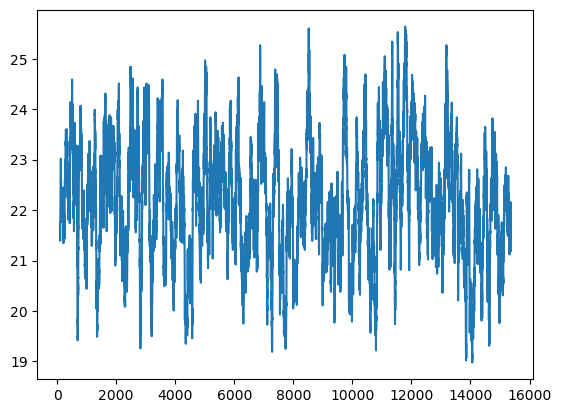

In [13]:
df = pd.DataFrame(data=total_rewards,columns=["reward"])
df["running_mean"] = df["reward"].rolling(window=100).mean()
plt.plot(df.running_mean[-20000:])
plt.show()

In [ ]:
np.array([np.random.choice([0,1]) for i in range(100000)]).mean()

In [ ]:
np.array([np.random.choice([0,1],1,[0.1,0.9]) for i in range(100)]).mean(
)

In [ ]:
nums = []
for i in range(100):
    nums.append(np.random.choice(2,1,p=[0.1,0.9])[0])

sum(nums)